In [1]:
import tensorflow as tf

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5



In [3]:
tf.test.is_gpu_available()

True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Activation, Conv2D, Add

In [6]:
import PIL
from PIL import Image

In [8]:
# Training parameters
num_train = 20 
max_color = 7

In [11]:
# Loading data for training
blurred_train_aux = np.zeros((num_train, 256, 256, 1))
original_train_aux = np.zeros((num_train, 256, 256, 1))

# Degraded by sigma = 2 and dimension = (7, 7) (gaussian blur)
for i in range (1, num_train):
    blurred_train_aux[i-1, :, :, 0] = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada' + str(i) + '.npy')
    original_train_aux[i-1, :, :, 0] = np.load('dataset_gray/original/8/arrays/original' + str(i) + '.npy')

In [12]:
# Normalizing data
blurred_train_aux = blurred_train_aux/(blurred_train_aux.max())
original_train_aux = original_train_aux/(original_train_aux.max())

In [13]:
# Range of data: -1 to 1
blurred_train = 2*blurred_train_aux - 1
original_train = 2*original_train_aux - 1

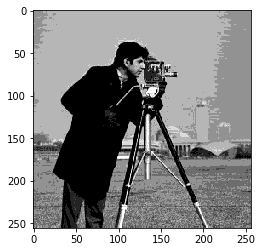

In [14]:
plt.imshow(original_train_aux[0, :, :, 0], cmap='gray')

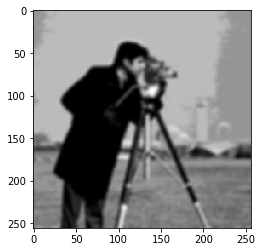

In [15]:
plt.imshow(blurred_train_aux[0, :, :, 0], cmap='gray')

In [16]:
# Converting data to tensor for SSIM comparations
blurred_train_tf = tf.convert_to_tensor(blurred_train_aux)
original_train_tf = tf.convert_to_tensor(original_train_aux)

In [19]:
# Loading data for testing
blurred_test_aux = np.zeros((2, 256, 256, 1))
original_test_aux = np.zeros((2, 256, 256, 1))

# Degraded by sigma = 2 and dimension = (7, 7) (gaussian blur)
blurred_test_aux[:, :, :, 0] = np.load('dataset_gray/sigma2(7, 7)/arrays/degradada.npy')
original_test_aux[:, :, :, 0] = np.load('dataset_gray/original/8/arrays/original.npy')

In [20]:
# Normalizing data
blurred_test_aux = blurred_test_aux/(blurred_test_aux.max())
original_test_aux = original_test_aux/(original_test_aux.max())

In [21]:
# Range of data: -1 to 1
blurred_test = 2*blurred_test_aux - 1
original_test = 2*original_test_aux - 1

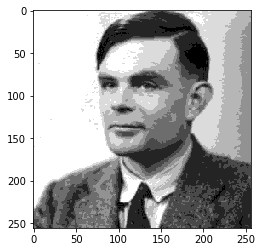

In [22]:
plt.imshow(original_test_aux[0, :, :, 0], cmap='gray')

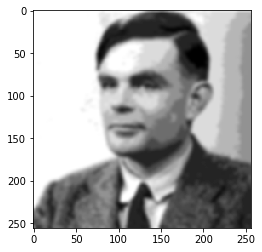

In [23]:
plt.imshow(blurred_test_aux[0, :, :, 0], cmap='gray')

In [24]:
# Converting data to tensor for SSIM comparations
blurred_test_tf = tf.convert_to_tensor(blurred_test_aux)
original_test_tf = tf.convert_to_tensor(original_test_aux)

In [25]:
# Network model
def make_autoencoder(input_shape):
  
    X_input = Input(input_shape)

    X = Conv2D(1, (7, 7), padding="same")(X_input)
    X0 = Activation('tanh')(X)
    
    X = Conv2D(4, (7, 7), padding="same")(X0)
    X1 = Activation('tanh')(X)
    
    X = Conv2D(8, (7, 7), padding="same")(X1)
    X2 = Activation('tanh')(X)
    
    X = Conv2D(16, (7, 7), padding="same")(X2)
    X3 = Activation('tanh')(X)
    
    X = Conv2D(32, (7, 7), padding="same")(X3)
    X = Activation('tanh')(X)
 
    #latent space
 
    X = Conv2D(16, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    X = Add()([X3, X])
    
    X = Conv2D(8, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    X = Add()([X2, X])
    
    X = Conv2D(4, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    X = Add()([X1, X])
    
    X = Conv2D(1, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    X = Add()([X0, X])
    
    X = Conv2D(1, (7, 7), padding="same")(X)
    X = Activation('tanh')(X)
    

    model = Model(inputs=X_input, outputs=X)
    
    return model

In [26]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

Number of devices: 2


In [27]:
opt = Adam(lr=1e-4)

In [28]:
# Training with 2 GPUs
with mirrored_strategy.scope():
    model = make_autoencoder(blurred_train.shape[1:])
    model.compile(optimizer=opt, loss='mse')

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 1)  50          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 1)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 4)  200         activation[0][0]                 
______________________________________________________________________________________________

In [27]:
history = model.fit(x=blurred_train, y=original_train, epochs=20000, validation_data=[blurred_test, original_test])

Train on 20 samples, validate on 2 samples
Epoch 1/20000
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then bro

Epoch 69/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0504 - val_loss: 0.0346
Epoch 70/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0502 - val_loss: 0.0344
Epoch 71/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0500 - val_loss: 0.0343
Epoch 72/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0498 - val_loss: 0.0342
Epoch 73/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0496 - val_loss: 0.0342
Epoch 74/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0494 - val_loss: 0.0341
Epoch 75/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0492 - val_loss: 0.0340
Epoch 76/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0491 - val_loss: 0.0339
Epoch 77/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0489 - val_loss: 0.0338
Epoch 78/20000
20/20 [==============================] - 0s 8ms/s

Epoch 148/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0408 - val_loss: 0.0257
Epoch 149/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0407 - val_loss: 0.0256
Epoch 150/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0406 - val_loss: 0.0255
Epoch 151/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0406 - val_loss: 0.0254
Epoch 152/20000
20/20 [==============================] - 0s 7ms/sample - loss: 0.0405 - val_loss: 0.0254
Epoch 153/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0404 - val_loss: 0.0253
Epoch 154/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0403 - val_loss: 0.0252
Epoch 155/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0402 - val_loss: 0.0252
Epoch 156/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0402 - val_loss: 0.0251
Epoch 157/20000
20/20 [==============================] 

20/20 [==============================] - 0s 8ms/sample - loss: 0.0359 - val_loss: 0.0215
Epoch 227/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0359 - val_loss: 0.0214
Epoch 228/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0358 - val_loss: 0.0214
Epoch 229/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0358 - val_loss: 0.0213
Epoch 230/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0357 - val_loss: 0.0213
Epoch 231/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0357 - val_loss: 0.0212
Epoch 232/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0356 - val_loss: 0.0212
Epoch 233/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0356 - val_loss: 0.0211
Epoch 234/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0355 - val_loss: 0.0211
Epoch 235/20000
20/20 [==============================] - 0s 8ms/sample 

Epoch 305/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0309 - val_loss: 0.0150
Epoch 306/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0309 - val_loss: 0.0148
Epoch 307/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0309 - val_loss: 0.0148
Epoch 308/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0309 - val_loss: 0.0149
Epoch 309/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0309 - val_loss: 0.0147
Epoch 310/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0308 - val_loss: 0.0147
Epoch 311/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0308 - val_loss: 0.0148
Epoch 312/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0308 - val_loss: 0.0146
Epoch 313/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0307 - val_loss: 0.0146
Epoch 314/20000
20/20 [==============================] 

20/20 [==============================] - 0s 8ms/sample - loss: 0.0292 - val_loss: 0.0132
Epoch 384/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0292 - val_loss: 0.0131
Epoch 385/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0292 - val_loss: 0.0134
Epoch 386/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0293 - val_loss: 0.0134
Epoch 387/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0297 - val_loss: 0.0139
Epoch 388/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0298 - val_loss: 0.0138
Epoch 389/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0301 - val_loss: 0.0134
Epoch 390/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0293 - val_loss: 0.0130
Epoch 391/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0290 - val_loss: 0.0132
Epoch 392/20000
20/20 [==============================] - 0s 8ms/sample 

Epoch 462/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0280 - val_loss: 0.0121
Epoch 463/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0280 - val_loss: 0.0121
Epoch 464/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0280 - val_loss: 0.0121
Epoch 465/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0280 - val_loss: 0.0121
Epoch 466/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0279 - val_loss: 0.0121
Epoch 467/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0279 - val_loss: 0.0121
Epoch 468/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0279 - val_loss: 0.0121
Epoch 469/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0279 - val_loss: 0.0120
Epoch 470/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0279 - val_loss: 0.0120
Epoch 471/20000
20/20 [==============================] 

20/20 [==============================] - 0s 8ms/sample - loss: 0.0272 - val_loss: 0.0115
Epoch 541/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0271 - val_loss: 0.0115
Epoch 542/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0271 - val_loss: 0.0115
Epoch 543/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0271 - val_loss: 0.0115
Epoch 544/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0271 - val_loss: 0.0114
Epoch 545/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0271 - val_loss: 0.0115
Epoch 546/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0271 - val_loss: 0.0114
Epoch 547/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0271 - val_loss: 0.0114
Epoch 548/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0271 - val_loss: 0.0114
Epoch 549/20000
20/20 [==============================] - 0s 8ms/sample 

Epoch 619/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0265 - val_loss: 0.0110
Epoch 620/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0265 - val_loss: 0.0111
Epoch 621/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0265 - val_loss: 0.0110
Epoch 622/20000
20/20 [==============================] - 0s 7ms/sample - loss: 0.0264 - val_loss: 0.0110
Epoch 623/20000
20/20 [==============================] - 0s 6ms/sample - loss: 0.0265 - val_loss: 0.0110
Epoch 624/20000
20/20 [==============================] - 0s 7ms/sample - loss: 0.0264 - val_loss: 0.0110
Epoch 625/20000
20/20 [==============================] - 0s 7ms/sample - loss: 0.0264 - val_loss: 0.0110
Epoch 626/20000
20/20 [==============================] - 0s 7ms/sample - loss: 0.0264 - val_loss: 0.0110
Epoch 627/20000
20/20 [==============================] - 0s 7ms/sample - loss: 0.0264 - val_loss: 0.0110
Epoch 628/20000
20/20 [==============================] 

Epoch 697/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0106
Epoch 698/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0106
Epoch 699/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0106
Epoch 700/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0106
Epoch 701/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0106
Epoch 702/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0106
Epoch 703/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0106
Epoch 704/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0106
Epoch 705/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0258 - val_loss: 0.0105
Epoch 706/20000
20/20 [==============================] 

20/20 [==============================] - 0s 8ms/sample - loss: 0.0253 - val_loss: 0.0103
Epoch 776/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0253 - val_loss: 0.0103
Epoch 777/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0253 - val_loss: 0.0103
Epoch 778/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0252 - val_loss: 0.0103
Epoch 779/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0252 - val_loss: 0.0103
Epoch 780/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0253 - val_loss: 0.0103
Epoch 781/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0252 - val_loss: 0.0103
Epoch 782/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0252 - val_loss: 0.0103
Epoch 783/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0252 - val_loss: 0.0103
Epoch 784/20000
20/20 [==============================] - 0s 8ms/sample 

Epoch 854/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0247 - val_loss: 0.0099
Epoch 855/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0247 - val_loss: 0.0099
Epoch 856/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0247 - val_loss: 0.0099
Epoch 857/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0247 - val_loss: 0.0099
Epoch 858/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0246 - val_loss: 0.0099
Epoch 859/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0246 - val_loss: 0.0099
Epoch 860/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0246 - val_loss: 0.0099
Epoch 861/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0246 - val_loss: 0.0099
Epoch 862/20000
20/20 [==============================] - 0s 7ms/sample - loss: 0.0246 - val_loss: 0.0099
Epoch 863/20000
20/20 [==============================] 

20/20 [==============================] - 0s 8ms/sample - loss: 0.0244 - val_loss: 0.0100
Epoch 933/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0245 - val_loss: 0.0104
Epoch 934/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0250 - val_loss: 0.0104
Epoch 935/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0250 - val_loss: 0.0105
Epoch 936/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0251 - val_loss: 0.0099
Epoch 937/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0244 - val_loss: 0.0095
Epoch 938/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0241 - val_loss: 0.0097
Epoch 939/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0242 - val_loss: 0.0100
Epoch 940/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0244 - val_loss: 0.0099
Epoch 941/20000
20/20 [==============================] - 0s 8ms/sample 

20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1011/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1012/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1013/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1014/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1015/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1016/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1017/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1018/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0235 - val_loss: 0.0092
Epoch 1019/20000
20/20 [==============================] - 0s 8m

Epoch 1088/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0233 - val_loss: 0.0089
Epoch 1089/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0230 - val_loss: 0.0089
Epoch 1090/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0230 - val_loss: 0.0090
Epoch 1091/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0231 - val_loss: 0.0088
Epoch 1092/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0230 - val_loss: 0.0088
Epoch 1093/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0230 - val_loss: 0.0090
Epoch 1094/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0231 - val_loss: 0.0088
Epoch 1095/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0229 - val_loss: 0.0088
Epoch 1096/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0229 - val_loss: 0.0089
Epoch 1097/20000
20/20 [======================

Epoch 1166/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0224 - val_loss: 0.0084
Epoch 1167/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0224 - val_loss: 0.0083
Epoch 1168/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0224 - val_loss: 0.0083
Epoch 1169/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0224 - val_loss: 0.0083
Epoch 1170/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0224 - val_loss: 0.0083
Epoch 1171/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0224 - val_loss: 0.0083
Epoch 1172/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0224 - val_loss: 0.0083
Epoch 1173/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0223 - val_loss: 0.0083
Epoch 1174/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0223 - val_loss: 0.0083
Epoch 1175/20000
20/20 [======================

Epoch 1244/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0219 - val_loss: 0.0081
Epoch 1245/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0220 - val_loss: 0.0081
Epoch 1246/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0220 - val_loss: 0.0080
Epoch 1247/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0219 - val_loss: 0.0081
Epoch 1248/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0220 - val_loss: 0.0080
Epoch 1249/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0219 - val_loss: 0.0081
Epoch 1250/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0219 - val_loss: 0.0080
Epoch 1251/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0219 - val_loss: 0.0080
Epoch 1252/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0219 - val_loss: 0.0080
Epoch 1253/20000
20/20 [======================

Epoch 1322/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0078
Epoch 1323/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0077
Epoch 1324/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0077
Epoch 1325/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0077
Epoch 1326/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0077
Epoch 1327/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0077
Epoch 1328/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0077
Epoch 1329/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0077
Epoch 1330/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0215 - val_loss: 0.0077
Epoch 1331/20000
20/20 [======================

Epoch 1400/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0076
Epoch 1401/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0076
Epoch 1402/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0076
Epoch 1403/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0075
Epoch 1404/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0075
Epoch 1405/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0075
Epoch 1406/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0075
Epoch 1407/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0075
Epoch 1408/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0211 - val_loss: 0.0075
Epoch 1409/20000
20/20 [======================

Epoch 1478/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0208 - val_loss: 0.0074
Epoch 1479/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0208 - val_loss: 0.0074
Epoch 1480/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0208 - val_loss: 0.0074
Epoch 1481/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0208 - val_loss: 0.0074
Epoch 1482/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0208 - val_loss: 0.0074
Epoch 1483/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0208 - val_loss: 0.0074
Epoch 1484/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0208 - val_loss: 0.0074
Epoch 1485/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0208 - val_loss: 0.0076
Epoch 1486/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0209 - val_loss: 0.0076
Epoch 1487/20000
20/20 [======================

Epoch 1556/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0073
Epoch 1557/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0073
Epoch 1558/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0073
Epoch 1559/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0073
Epoch 1560/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0073
Epoch 1561/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0073
Epoch 1562/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0073
Epoch 1563/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0073
Epoch 1564/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0204 - val_loss: 0.0072
Epoch 1565/20000
20/20 [======================

Epoch 1634/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1635/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1636/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1637/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1638/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1639/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1640/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1641/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1642/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0201 - val_loss: 0.0071
Epoch 1643/20000
20/20 [======================

Epoch 1712/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0198 - val_loss: 0.0070
Epoch 1713/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0198 - val_loss: 0.0070
Epoch 1714/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0198 - val_loss: 0.0070
Epoch 1715/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0198 - val_loss: 0.0070
Epoch 1716/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0198 - val_loss: 0.0070
Epoch 1717/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0197 - val_loss: 0.0070
Epoch 1718/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0197 - val_loss: 0.0070
Epoch 1719/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0197 - val_loss: 0.0070
Epoch 1720/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0197 - val_loss: 0.0070
Epoch 1721/20000
20/20 [======================

Epoch 1790/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0195 - val_loss: 0.0069
Epoch 1791/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0194 - val_loss: 0.0069
Epoch 1792/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0195 - val_loss: 0.0069
Epoch 1793/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0194 - val_loss: 0.0069
Epoch 1794/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0194 - val_loss: 0.0069
Epoch 1795/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0194 - val_loss: 0.0069
Epoch 1796/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0194 - val_loss: 0.0069
Epoch 1797/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0194 - val_loss: 0.0069
Epoch 1798/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0194 - val_loss: 0.0069
Epoch 1799/20000
20/20 [======================

Epoch 1868/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1869/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1870/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1871/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1872/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1873/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1874/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1875/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1876/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0191 - val_loss: 0.0068
Epoch 1877/20000
20/20 [======================

Epoch 1946/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1947/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1948/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1949/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1950/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1951/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1952/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1953/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1954/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 1955/20000
20/20 [======================

Epoch 2024/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0187 - val_loss: 0.0068
Epoch 2025/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0189 - val_loss: 0.0066
Epoch 2026/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0186 - val_loss: 0.0069
Epoch 2027/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 2028/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0187 - val_loss: 0.0066
Epoch 2029/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0186 - val_loss: 0.0070
Epoch 2030/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0188 - val_loss: 0.0067
Epoch 2031/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0186 - val_loss: 0.0067
Epoch 2032/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0186 - val_loss: 0.0068
Epoch 2033/20000
20/20 [======================

Epoch 2102/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2103/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2104/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2105/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2106/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2107/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2108/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2109/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2110/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0183 - val_loss: 0.0065
Epoch 2111/20000
20/20 [======================

Epoch 2180/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2181/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2182/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2183/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2184/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2185/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2186/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2187/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2188/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0181 - val_loss: 0.0064
Epoch 2189/20000
20/20 [======================

Epoch 2258/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2259/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2260/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2261/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2262/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2263/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2264/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2265/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2266/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0178 - val_loss: 0.0063
Epoch 2267/20000
20/20 [======================

Epoch 2336/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2337/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2338/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2339/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2340/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2341/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2342/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2343/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2344/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0176 - val_loss: 0.0062
Epoch 2345/20000
20/20 [======================

Epoch 2414/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2415/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2416/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2417/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2418/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2419/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2420/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2421/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2422/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0174 - val_loss: 0.0061
Epoch 2423/20000
20/20 [======================

Epoch 2492/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0061
Epoch 2493/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0061
Epoch 2494/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0060
Epoch 2495/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0060
Epoch 2496/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0060
Epoch 2497/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0060
Epoch 2498/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0060
Epoch 2499/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0060
Epoch 2500/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0172 - val_loss: 0.0060
Epoch 2501/20000
20/20 [======================

Epoch 2570/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2571/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2572/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2573/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2574/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2575/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2576/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2577/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2578/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0060
Epoch 2579/20000
20/20 [======================

Epoch 2648/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2649/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2650/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2651/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2652/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2653/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2654/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2655/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2656/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0059
Epoch 2657/20000
20/20 [======================

Epoch 2726/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2727/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2728/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2729/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2730/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2731/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2732/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2733/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2734/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0167 - val_loss: 0.0059
Epoch 2735/20000
20/20 [======================

Epoch 2804/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2805/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2806/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2807/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2808/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2809/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2810/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2811/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2812/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0165 - val_loss: 0.0058
Epoch 2813/20000
20/20 [======================

Epoch 2882/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0164 - val_loss: 0.0057
Epoch 2883/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0164 - val_loss: 0.0058
Epoch 2884/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0164 - val_loss: 0.0058
Epoch 2885/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0164 - val_loss: 0.0059
Epoch 2886/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0166 - val_loss: 0.0061
Epoch 2887/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0168 - val_loss: 0.0065
Epoch 2888/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0171 - val_loss: 0.0066
Epoch 2889/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0173 - val_loss: 0.0064
Epoch 2890/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0170 - val_loss: 0.0061
Epoch 2891/20000
20/20 [======================

Epoch 2960/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2961/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2962/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2963/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2964/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2965/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2966/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2967/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2968/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0162 - val_loss: 0.0056
Epoch 2969/20000
20/20 [======================

Epoch 3038/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3039/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3040/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3041/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3042/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3043/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3044/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3045/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3046/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0160 - val_loss: 0.0056
Epoch 3047/20000
20/20 [======================

Epoch 3116/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3117/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3118/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3119/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3120/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3121/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3122/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3123/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3124/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0055
Epoch 3125/20000
20/20 [======================

Epoch 3194/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3195/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3196/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3197/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3198/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3199/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3200/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3201/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3202/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0158 - val_loss: 0.0055
Epoch 3203/20000
20/20 [======================

Epoch 3272/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0157 - val_loss: 0.0054
Epoch 3273/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0157 - val_loss: 0.0054
Epoch 3274/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0157 - val_loss: 0.0054
Epoch 3275/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0157 - val_loss: 0.0054
Epoch 3276/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0157 - val_loss: 0.0054
Epoch 3277/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0157 - val_loss: 0.0055
Epoch 3278/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0157 - val_loss: 0.0055
Epoch 3279/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0158 - val_loss: 0.0056
Epoch 3280/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0159 - val_loss: 0.0057
Epoch 3281/20000
20/20 [======================

Epoch 3350/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0155 - val_loss: 0.0054
Epoch 3351/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0155 - val_loss: 0.0054
Epoch 3352/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0155 - val_loss: 0.0054
Epoch 3353/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0155 - val_loss: 0.0054
Epoch 3354/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0155 - val_loss: 0.0054
Epoch 3355/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0155 - val_loss: 0.0054
Epoch 3356/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0155 - val_loss: 0.0054
Epoch 3357/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0155 - val_loss: 0.0053
Epoch 3358/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0155 - val_loss: 0.0054
Epoch 3359/20000
20/20 [======================

Epoch 3428/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3429/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3430/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3431/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3432/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3433/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3434/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3435/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3436/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0154 - val_loss: 0.0053
Epoch 3437/20000
20/20 [======================

Epoch 3506/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0153 - val_loss: 0.0053
Epoch 3507/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0153 - val_loss: 0.0053
Epoch 3508/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0153 - val_loss: 0.0053
Epoch 3509/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0153 - val_loss: 0.0053
Epoch 3510/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0153 - val_loss: 0.0053
Epoch 3511/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0154 - val_loss: 0.0054
Epoch 3512/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0154 - val_loss: 0.0055
Epoch 3513/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0155 - val_loss: 0.0055
Epoch 3514/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0156 - val_loss: 0.0056
Epoch 3515/20000
20/20 [======================

Epoch 3584/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3585/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3586/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3587/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3588/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3589/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3590/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3591/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3592/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0152 - val_loss: 0.0052
Epoch 3593/20000
20/20 [======================

Epoch 3662/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3663/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3664/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3665/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3666/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3667/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3668/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3669/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3670/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3671/20000
20/20 [======================

Epoch 3740/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0152 - val_loss: 0.0053
Epoch 3741/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3742/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3743/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3744/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3745/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3746/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3747/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0051
Epoch 3748/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3749/20000
20/20 [======================

Epoch 3818/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0051
Epoch 3819/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0051
Epoch 3820/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0051
Epoch 3821/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0051
Epoch 3822/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0052
Epoch 3823/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3824/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3825/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0053
Epoch 3826/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0151 - val_loss: 0.0052
Epoch 3827/20000
20/20 [======================

Epoch 3896/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0149 - val_loss: 0.0052
Epoch 3897/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0052
Epoch 3898/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3899/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0150 - val_loss: 0.0053
Epoch 3900/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0150 - val_loss: 0.0052
Epoch 3901/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0150 - val_loss: 0.0053
Epoch 3902/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0149 - val_loss: 0.0052
Epoch 3903/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0149 - val_loss: 0.0052
Epoch 3904/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0052
Epoch 3905/20000
20/20 [======================

Epoch 3974/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0147 - val_loss: 0.0050
Epoch 3975/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0147 - val_loss: 0.0051
Epoch 3976/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0147 - val_loss: 0.0050
Epoch 3977/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0147 - val_loss: 0.0051
Epoch 3978/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0148 - val_loss: 0.0051
Epoch 3979/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0148 - val_loss: 0.0052
Epoch 3980/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0052
Epoch 3981/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0149 - val_loss: 0.0052
Epoch 3982/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0149 - val_loss: 0.0051
Epoch 3983/20000
20/20 [======================

Epoch 4052/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4053/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4054/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4055/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4056/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4057/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4058/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4059/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4060/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0146 - val_loss: 0.0050
Epoch 4061/20000
20/20 [======================

Epoch 4130/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4131/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4132/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4133/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4134/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4135/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4136/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4137/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4138/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4139/20000
20/20 [======================

Epoch 4208/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0144 - val_loss: 0.0049
Epoch 4209/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0145 - val_loss: 0.0049
Epoch 4210/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0144 - val_loss: 0.0049
Epoch 4211/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0144 - val_loss: 0.0049
Epoch 4212/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0144 - val_loss: 0.0049
Epoch 4213/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0144 - val_loss: 0.0049
Epoch 4214/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0144 - val_loss: 0.0049
Epoch 4215/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0144 - val_loss: 0.0049
Epoch 4216/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0144 - val_loss: 0.0049
Epoch 4217/20000
20/20 [======================

Epoch 4286/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0051
Epoch 4287/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0050
Epoch 4288/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0145 - val_loss: 0.0050
Epoch 4289/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0050
Epoch 4290/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0145 - val_loss: 0.0050
Epoch 4291/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0050
Epoch 4292/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0050
Epoch 4293/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0145 - val_loss: 0.0050
Epoch 4294/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0145 - val_loss: 0.0050
Epoch 4295/20000
20/20 [======================

Epoch 4364/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0143 - val_loss: 0.0049
Epoch 4365/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0143 - val_loss: 0.0049
Epoch 4366/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0143 - val_loss: 0.0050
Epoch 4367/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0144 - val_loss: 0.0050
Epoch 4368/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0144 - val_loss: 0.0050
Epoch 4369/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0144 - val_loss: 0.0050
Epoch 4370/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0144 - val_loss: 0.0050
Epoch 4371/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0144 - val_loss: 0.0050
Epoch 4372/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0144 - val_loss: 0.0050
Epoch 4373/20000
20/20 [======================

Epoch 4442/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4443/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4444/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4445/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4446/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4447/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4448/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4449/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4450/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0142 - val_loss: 0.0048
Epoch 4451/20000
20/20 [======================

Epoch 4520/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4521/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4522/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4523/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4524/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4525/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4526/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4527/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4528/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4529/20000
20/20 [======================

Epoch 4598/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4599/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4600/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4601/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0048
Epoch 4602/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4603/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4604/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4605/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4606/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4607/20000
20/20 [======================

Epoch 4676/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4677/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0047
Epoch 4678/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0047
Epoch 4679/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4680/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4681/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4682/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0047
Epoch 4683/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0047
Epoch 4684/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0048
Epoch 4685/20000
20/20 [======================

Epoch 4754/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0139 - val_loss: 0.0047
Epoch 4755/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0139 - val_loss: 0.0048
Epoch 4756/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0139 - val_loss: 0.0048
Epoch 4757/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0139 - val_loss: 0.0048
Epoch 4758/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0139 - val_loss: 0.0048
Epoch 4759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0139 - val_loss: 0.0047
Epoch 4760/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0139 - val_loss: 0.0047
Epoch 4761/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0139 - val_loss: 0.0048
Epoch 4762/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0139 - val_loss: 0.0047
Epoch 4763/20000
20/20 [======================

Epoch 4832/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0139 - val_loss: 0.0049
Epoch 4833/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0140 - val_loss: 0.0049
Epoch 4834/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0050
Epoch 4835/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0142 - val_loss: 0.0050
Epoch 4836/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0142 - val_loss: 0.0051
Epoch 4837/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0142 - val_loss: 0.0050
Epoch 4838/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0050
Epoch 4839/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0141 - val_loss: 0.0049
Epoch 4840/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0049
Epoch 4841/20000
20/20 [======================

Epoch 4910/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 4911/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 4912/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 4913/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 4914/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4915/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 4916/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 4917/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4918/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 4919/20000
20/20 [======================

Epoch 4988/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4989/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4990/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 4991/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4992/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4993/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4994/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4995/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4996/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 4997/20000
20/20 [======================

Epoch 5066/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5067/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5068/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5069/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5070/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5071/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5072/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5073/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5074/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0136 - val_loss: 0.0046
Epoch 5075/20000
20/20 [======================

Epoch 5144/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0049
Epoch 5145/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0138 - val_loss: 0.0049
Epoch 5146/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0139 - val_loss: 0.0051
Epoch 5147/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0139 - val_loss: 0.0048
Epoch 5148/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0138 - val_loss: 0.0047
Epoch 5149/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0048
Epoch 5150/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0048
Epoch 5151/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 5152/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0137 - val_loss: 0.0046
Epoch 5153/20000
20/20 [======================

Epoch 5222/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5223/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5224/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5225/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5226/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0047
Epoch 5227/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0047
Epoch 5228/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0136 - val_loss: 0.0047
Epoch 5229/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 5230/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0137 - val_loss: 0.0047
Epoch 5231/20000
20/20 [======================

Epoch 5300/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0134 - val_loss: 0.0046
Epoch 5301/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0134 - val_loss: 0.0046
Epoch 5302/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5303/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0047
Epoch 5304/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5305/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0047
Epoch 5306/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0136 - val_loss: 0.0047
Epoch 5307/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0136 - val_loss: 0.0047
Epoch 5308/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5309/20000
20/20 [======================

Epoch 5378/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5379/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0135 - val_loss: 0.0047
Epoch 5380/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5381/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0047
Epoch 5382/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5383/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5384/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0134 - val_loss: 0.0046
Epoch 5385/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0134 - val_loss: 0.0046
Epoch 5386/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0134 - val_loss: 0.0047
Epoch 5387/20000
20/20 [======================

Epoch 5456/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0134 - val_loss: 0.0047
Epoch 5457/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0047
Epoch 5458/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0047
Epoch 5459/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0135 - val_loss: 0.0047
Epoch 5460/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0135 - val_loss: 0.0048
Epoch 5461/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0046
Epoch 5462/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0134 - val_loss: 0.0046
Epoch 5463/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0134 - val_loss: 0.0047
Epoch 5464/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0135 - val_loss: 0.0047
Epoch 5465/20000
20/20 [======================

Epoch 5534/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5535/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5536/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5537/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5538/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5539/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5540/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5541/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5542/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5543/20000
20/20 [======================

Epoch 5612/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5613/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5614/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5615/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5616/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5617/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5618/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5619/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5620/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0132 - val_loss: 0.0045
Epoch 5621/20000
20/20 [======================

Epoch 5690/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5691/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5692/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5693/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5694/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5695/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5696/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5697/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5698/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5699/20000
20/20 [======================

Epoch 5768/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5769/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5770/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0044
Epoch 5771/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0044
Epoch 5772/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5773/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0044
Epoch 5774/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5775/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0131 - val_loss: 0.0044
Epoch 5776/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0044
Epoch 5777/20000
20/20 [======================

Epoch 5846/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5847/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5848/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5849/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5850/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5851/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5852/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5853/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5854/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5855/20000
20/20 [======================

Epoch 5924/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0045
Epoch 5925/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0046
Epoch 5926/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0045
Epoch 5927/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0045
Epoch 5928/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0130 - val_loss: 0.0045
Epoch 5929/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0044
Epoch 5930/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0045
Epoch 5931/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0130 - val_loss: 0.0045
Epoch 5932/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0045
Epoch 5933/20000
20/20 [======================

Epoch 6002/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6003/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6004/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6005/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6006/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6007/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6008/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6009/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6010/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0129 - val_loss: 0.0044
Epoch 6011/20000
20/20 [======================

Epoch 6080/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6081/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6082/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6083/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6084/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6085/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6086/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6087/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6088/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6089/20000
20/20 [======================

Epoch 6158/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6159/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6160/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6161/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6162/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6163/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6164/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6165/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6166/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6167/20000
20/20 [======================

Epoch 6236/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0129 - val_loss: 0.0045
Epoch 6237/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6238/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6239/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0045
Epoch 6240/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6241/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6242/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0043
Epoch 6243/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0127 - val_loss: 0.0044
Epoch 6244/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0044
Epoch 6245/20000
20/20 [======================

Epoch 6314/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0129 - val_loss: 0.0045
Epoch 6315/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0128 - val_loss: 0.0047
Epoch 6316/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0130 - val_loss: 0.0046
Epoch 6317/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0131 - val_loss: 0.0046
Epoch 6318/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0129 - val_loss: 0.0045
Epoch 6319/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0045
Epoch 6320/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0128 - val_loss: 0.0047
Epoch 6321/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0129 - val_loss: 0.0045
Epoch 6322/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0129 - val_loss: 0.0045
Epoch 6323/20000
20/20 [======================

Epoch 6392/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6393/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6394/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6395/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6396/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6397/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6398/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6399/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6400/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6401/20000
20/20 [======================

Epoch 6470/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6471/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6472/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6473/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6474/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6475/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6476/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6477/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6478/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0126 - val_loss: 0.0043
Epoch 6479/20000
20/20 [======================

Epoch 6548/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6549/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6550/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6551/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6552/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6553/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6554/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6555/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6556/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6557/20000
20/20 [======================

Epoch 6626/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6627/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6628/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6629/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6630/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6631/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6632/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6633/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6634/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0125 - val_loss: 0.0043
Epoch 6635/20000
20/20 [======================

Epoch 6704/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6705/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6706/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6707/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6708/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6709/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6710/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6711/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6712/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6713/20000
20/20 [======================

Epoch 6782/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6783/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6784/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6785/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6786/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6787/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6788/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6789/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6790/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6791/20000
20/20 [======================

Epoch 6860/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6861/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6862/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6863/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6864/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6865/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6866/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0042
Epoch 6867/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 6868/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 6869/20000
20/20 [======================

Epoch 6938/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6939/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6940/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0043
Epoch 6941/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 6942/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 6943/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 6944/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 6945/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 6946/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 6947/20000
20/20 [======================

Epoch 7016/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7017/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7018/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7019/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0042
Epoch 7020/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7021/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7022/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7023/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7024/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0042
Epoch 7025/20000
20/20 [======================

Epoch 7094/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7095/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7096/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7097/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7098/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7099/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7100/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7101/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7102/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7103/20000
20/20 [======================

Epoch 7172/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7173/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7174/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7175/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0043
Epoch 7176/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7177/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7178/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7179/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7180/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7181/20000
20/20 [======================

Epoch 7250/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7251/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7252/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7253/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7254/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7255/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7256/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7257/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7258/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7259/20000
20/20 [======================

Epoch 7328/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7329/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7330/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7331/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7332/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7333/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7334/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7335/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0042
Epoch 7336/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7337/20000
20/20 [======================

Epoch 7406/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7407/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7408/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7409/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7410/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7411/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7412/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7413/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7414/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7415/20000
20/20 [======================

Epoch 7484/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7485/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7486/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7487/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7488/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7489/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7490/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7491/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0043
Epoch 7492/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7493/20000
20/20 [======================

Epoch 7562/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0043
Epoch 7563/20000
20/20 [==============================] - 0s 7ms/sample - loss: 0.0121 - val_loss: 0.0043
Epoch 7564/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0044
Epoch 7565/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0043
Epoch 7566/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0043
Epoch 7567/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7568/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7569/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0043
Epoch 7570/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7571/20000
20/20 [======================

Epoch 7640/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0043
Epoch 7641/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7642/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7643/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7644/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7645/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7646/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7647/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7648/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7649/20000
20/20 [======================

Epoch 7718/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7719/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0044
Epoch 7720/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0043
Epoch 7721/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0042
Epoch 7722/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7723/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7724/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0120 - val_loss: 0.0043
Epoch 7725/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0120 - val_loss: 0.0043
Epoch 7726/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0121 - val_loss: 0.0043
Epoch 7727/20000
20/20 [======================

Epoch 7796/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 7797/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 7798/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7799/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0120 - val_loss: 0.0043
Epoch 7800/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0043
Epoch 7801/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0121 - val_loss: 0.0044
Epoch 7802/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0044
Epoch 7803/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0122 - val_loss: 0.0045
Epoch 7804/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0122 - val_loss: 0.0044
Epoch 7805/20000
20/20 [======================

Epoch 7874/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7875/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7876/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7877/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7878/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7879/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7880/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7881/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7882/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0041
Epoch 7883/20000
20/20 [======================

Epoch 7952/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 7953/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 7954/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 7955/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 7956/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 7957/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 7958/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 7959/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 7960/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0042
Epoch 7961/20000
20/20 [======================

Epoch 8030/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8031/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8032/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8033/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8034/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8035/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8036/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8037/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8038/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8039/20000
20/20 [======================

Epoch 8108/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8109/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8110/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8111/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8112/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8113/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8114/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8115/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8116/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8117/20000
20/20 [======================

Epoch 8186/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8187/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8188/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8189/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8190/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8191/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8192/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8193/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8194/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8195/20000
20/20 [======================

Epoch 8264/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0041
Epoch 8265/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0041
Epoch 8266/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0041
Epoch 8267/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0041
Epoch 8268/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8269/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8270/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0043
Epoch 8271/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0043
Epoch 8272/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0120 - val_loss: 0.0044
Epoch 8273/20000
20/20 [======================

Epoch 8342/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0043
Epoch 8343/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0043
Epoch 8344/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0042
Epoch 8345/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0042
Epoch 8346/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0043
Epoch 8347/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0043
Epoch 8348/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0043
Epoch 8349/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0042
Epoch 8350/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8351/20000
20/20 [======================

Epoch 8420/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8421/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8422/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8423/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8424/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0117 - val_loss: 0.0041
Epoch 8425/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0117 - val_loss: 0.0041
Epoch 8426/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0117 - val_loss: 0.0041
Epoch 8427/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0117 - val_loss: 0.0042
Epoch 8428/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0117 - val_loss: 0.0042
Epoch 8429/20000
20/20 [======================

Epoch 8498/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8499/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8500/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8501/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8502/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8503/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8504/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8505/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8506/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8507/20000
20/20 [======================

Epoch 8576/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8577/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8578/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8579/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8580/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8581/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8582/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8583/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8584/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8585/20000
20/20 [======================

Epoch 8654/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8655/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8656/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8657/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8658/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8659/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8660/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8661/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8662/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8663/20000
20/20 [======================

Epoch 8732/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8733/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8734/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8735/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8736/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8737/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8738/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8739/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8740/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8741/20000
20/20 [======================

Epoch 8810/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0043
Epoch 8811/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0044
Epoch 8812/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0118 - val_loss: 0.0044
Epoch 8813/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0043
Epoch 8814/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0043
Epoch 8815/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0118 - val_loss: 0.0041
Epoch 8816/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8817/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0042
Epoch 8818/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0117 - val_loss: 0.0041
Epoch 8819/20000
20/20 [======================

Epoch 8888/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8889/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8890/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8891/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8892/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8893/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8894/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8895/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8896/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8897/20000
20/20 [======================

Epoch 8966/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8967/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0041
Epoch 8968/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0042
Epoch 8969/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0042
Epoch 8970/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0042
Epoch 8971/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0042
Epoch 8972/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0042
Epoch 8973/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8974/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0041
Epoch 8975/20000
20/20 [======================

Epoch 9044/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9045/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9046/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9047/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9048/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9049/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9050/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9051/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9052/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9053/20000
20/20 [======================

Epoch 9122/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9123/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9124/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9125/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9126/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9127/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9128/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9129/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9130/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9131/20000
20/20 [======================

Epoch 9200/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9201/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9202/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9203/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9204/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9205/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9206/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9207/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9208/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9209/20000
20/20 [======================

Epoch 9278/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0043
Epoch 9279/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0042
Epoch 9280/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0043
Epoch 9281/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0042
Epoch 9282/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0045
Epoch 9283/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0043
Epoch 9284/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0116 - val_loss: 0.0044
Epoch 9285/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0042
Epoch 9286/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0042
Epoch 9287/20000
20/20 [======================

Epoch 9356/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9357/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9358/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9359/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9360/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0042
Epoch 9361/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9362/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9363/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9364/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9365/20000
20/20 [======================

Epoch 9434/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9435/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9436/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9437/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9438/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9439/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9440/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9441/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9442/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9443/20000
20/20 [======================

Epoch 9512/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9513/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9514/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9515/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9516/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9517/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9518/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9519/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9520/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9521/20000
20/20 [======================

Epoch 9590/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0043
Epoch 9591/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0042
Epoch 9592/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0040
Epoch 9593/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 9594/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 9595/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9596/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0042
Epoch 9597/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0041
Epoch 9598/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9599/20000
20/20 [======================

Epoch 9668/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9669/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9670/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9671/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9672/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9673/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9674/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9675/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9676/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9677/20000
20/20 [======================

Epoch 9746/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9747/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9748/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9749/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9750/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9751/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9752/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 9753/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9754/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 9755/20000
20/20 [======================

Epoch 9824/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9825/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9826/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9827/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9828/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9829/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9830/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9831/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9832/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 9833/20000
20/20 [======================

Epoch 9902/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0143 - val_loss: 0.0081
Epoch 9903/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0078
Epoch 9904/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0078
Epoch 9905/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0141 - val_loss: 0.0076
Epoch 9906/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0140 - val_loss: 0.0075
Epoch 9907/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0139 - val_loss: 0.0074
Epoch 9908/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0138 - val_loss: 0.0074
Epoch 9909/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0138 - val_loss: 0.0074
Epoch 9910/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0138 - val_loss: 0.0072
Epoch 9911/20000
20/20 [======================

Epoch 9980/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0056
Epoch 9981/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0056
Epoch 9982/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0124 - val_loss: 0.0056
Epoch 9983/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0055
Epoch 9984/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0055
Epoch 9985/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0055
Epoch 9986/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0123 - val_loss: 0.0055
Epoch 9987/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0055
Epoch 9988/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0123 - val_loss: 0.0055
Epoch 9989/20000
20/20 [======================

Epoch 10057/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10058/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10059/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10060/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10061/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10062/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10063/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10064/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10065/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0050
Epoch 10066/20000
20/20 [============

Epoch 10134/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0047
Epoch 10135/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0047
Epoch 10136/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0046
Epoch 10137/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0117 - val_loss: 0.0046
Epoch 10138/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0046
Epoch 10139/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0046
Epoch 10140/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0117 - val_loss: 0.0046
Epoch 10141/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0046
Epoch 10142/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0046
Epoch 10143/20000
20/20 [============

Epoch 10211/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10212/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10213/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10214/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10215/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10216/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10217/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10218/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10219/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0044
Epoch 10220/20000
20/20 [============

Epoch 10288/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10289/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10290/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10291/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10292/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10293/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10294/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10295/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10296/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0114 - val_loss: 0.0043
Epoch 10297/20000
20/20 [============

Epoch 10365/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10366/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10367/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10368/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10369/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10370/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10371/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10372/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10373/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10374/20000
20/20 [============

Epoch 10442/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10443/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10444/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10445/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10446/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10447/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10448/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10449/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10450/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10451/20000
20/20 [============

Epoch 10519/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10520/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10521/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10522/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10523/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10524/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10525/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10526/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10527/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10528/20000
20/20 [============

Epoch 10596/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10597/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10598/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10599/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10600/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10601/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10602/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10603/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10604/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10605/20000
20/20 [============

Epoch 10673/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10674/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10675/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10676/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10677/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10678/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10679/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10680/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10681/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10682/20000
20/20 [============

Epoch 10750/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0042
Epoch 10751/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10752/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10753/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 10754/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10755/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10756/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10757/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10758/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10759/20000
20/20 [============

Epoch 10827/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10828/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10829/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10830/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10831/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10832/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10833/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10834/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10835/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10836/20000
20/20 [============

Epoch 10904/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10905/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10906/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10907/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10908/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10909/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10910/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10911/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10912/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 10913/20000
20/20 [============

Epoch 10981/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10982/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0042
Epoch 10983/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 10984/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 10985/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 10986/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 10987/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10988/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10989/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 10990/20000
20/20 [============

Epoch 11058/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11059/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11060/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11061/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11062/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11063/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11064/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11065/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11066/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11067/20000
20/20 [============

Epoch 11135/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11136/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11137/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11138/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11139/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11140/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11141/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11142/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11143/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11144/20000
20/20 [============

Epoch 11212/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 11213/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 11214/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11215/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 11216/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 11217/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 11218/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 11219/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11220/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 11221/20000
20/20 [============

Epoch 11289/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11290/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11291/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11292/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11293/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11294/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11295/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11296/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11297/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11298/20000
20/20 [============

Epoch 11366/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11367/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11368/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11369/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11370/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11371/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11372/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11373/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11374/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11375/20000
20/20 [============

Epoch 11443/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0046
Epoch 11444/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0045
Epoch 11445/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0043
Epoch 11446/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0040
Epoch 11447/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11448/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0042
Epoch 11449/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0042
Epoch 11450/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 11451/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 11452/20000
20/20 [============

Epoch 11520/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11521/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11522/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11523/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11524/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11525/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11526/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11527/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11528/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11529/20000
20/20 [============

Epoch 11597/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11598/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11599/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11600/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11601/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11602/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11603/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11604/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11605/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11606/20000
20/20 [============

Epoch 11674/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0116 - val_loss: 0.0045
Epoch 11675/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0045
Epoch 11676/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0115 - val_loss: 0.0042
Epoch 11677/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 11678/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11679/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0042
Epoch 11680/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0042
Epoch 11681/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0042
Epoch 11682/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 11683/20000
20/20 [============

Epoch 11751/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11752/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11753/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11754/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11755/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11756/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11757/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11758/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11760/20000
20/20 [============

Epoch 11828/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11829/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11830/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11831/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11832/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11833/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11834/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11835/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11836/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11837/20000
20/20 [============

Epoch 11905/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0042
Epoch 11906/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0041
Epoch 11907/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11908/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0041
Epoch 11909/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0041
Epoch 11910/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 11911/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11912/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0041
Epoch 11913/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11914/20000
20/20 [============

Epoch 11982/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11983/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11984/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11985/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11986/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11987/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11988/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11989/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11990/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 11991/20000
20/20 [============

Epoch 12059/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12060/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12061/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12062/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12063/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12064/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12065/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12066/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12067/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12068/20000
20/20 [============

Epoch 12136/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0040
Epoch 12137/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12138/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0043
Epoch 12139/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0043
Epoch 12140/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0113 - val_loss: 0.0041
Epoch 12141/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0040
Epoch 12142/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0110 - val_loss: 0.0041
Epoch 12143/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0042
Epoch 12144/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0111 - val_loss: 0.0040
Epoch 12145/20000
20/20 [============

Epoch 12213/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12214/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12215/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12216/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12217/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12218/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12219/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12220/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12221/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12222/20000
20/20 [============

Epoch 12290/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12291/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12292/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12293/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12294/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12295/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12296/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12297/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12298/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12299/20000
20/20 [============

Epoch 12367/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12368/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12369/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12370/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0042
Epoch 12371/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0043
Epoch 12372/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0113 - val_loss: 0.0046
Epoch 12373/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0115 - val_loss: 0.0049
Epoch 12374/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0119 - val_loss: 0.0048
Epoch 12375/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0117 - val_loss: 0.0046
Epoch 12376/20000
20/20 [============

Epoch 12444/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12445/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12446/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12447/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12448/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12449/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12450/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12451/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12452/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12453/20000
20/20 [============

Epoch 12521/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12522/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12523/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12524/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12525/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12526/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12527/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12528/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12529/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12530/20000
20/20 [============

Epoch 12598/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12599/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12600/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12601/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12602/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12603/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12604/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12605/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12606/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0039
Epoch 12607/20000
20/20 [============

Epoch 12675/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12676/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12677/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12678/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12679/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12680/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0109 - val_loss: 0.0040
Epoch 12681/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12682/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12683/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12684/20000
20/20 [============

Epoch 12752/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12753/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12754/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12755/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12756/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12757/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12758/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12760/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12761/20000
20/20 [============

Epoch 12829/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12830/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12831/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12832/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12833/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12834/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12835/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12836/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12837/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12838/20000
20/20 [============

Epoch 12906/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12907/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12908/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12909/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12910/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12911/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12912/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12913/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12914/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 12915/20000
20/20 [============

Epoch 12983/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12984/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12985/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12986/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12987/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12988/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12989/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12990/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12991/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 12992/20000
20/20 [============

Epoch 13060/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13061/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13062/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13063/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13064/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13065/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13066/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13067/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13068/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13069/20000
20/20 [============

Epoch 13137/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13138/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13139/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13140/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13141/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13142/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13143/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13144/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13145/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13146/20000
20/20 [============

Epoch 13214/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13215/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13216/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13217/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13218/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13219/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13220/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13221/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13222/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13223/20000
20/20 [============

Epoch 13291/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13292/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13293/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13294/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13295/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13296/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13297/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13298/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13299/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13300/20000
20/20 [============

Epoch 13368/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13369/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13370/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13371/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13372/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13373/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13374/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13375/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13376/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13377/20000
20/20 [============

Epoch 13445/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13446/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13447/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13448/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13449/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13450/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13451/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13452/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13453/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13454/20000
20/20 [============

Epoch 13522/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13523/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13524/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13525/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13526/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13527/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13528/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13529/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13530/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13531/20000
20/20 [============

Epoch 13599/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13600/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0041
Epoch 13601/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13602/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13603/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13604/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13605/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13606/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13607/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13608/20000
20/20 [============

Epoch 13676/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13677/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13678/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13679/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13680/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0040
Epoch 13681/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0108 - val_loss: 0.0039
Epoch 13682/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13683/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13684/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13685/20000
20/20 [============

Epoch 13753/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13754/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13755/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13756/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13757/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13758/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13759/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13760/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13761/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13762/20000
20/20 [============

Epoch 13830/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13831/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13832/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13833/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13834/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0108 - val_loss: 0.0041
Epoch 13835/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0042
Epoch 13836/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0110 - val_loss: 0.0043
Epoch 13837/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0111 - val_loss: 0.0043
Epoch 13838/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0112 - val_loss: 0.0043
Epoch 13839/20000
20/20 [============

Epoch 13907/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13908/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13909/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13910/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13911/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13912/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13913/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13914/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13915/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13916/20000
20/20 [============

Epoch 13984/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13985/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13986/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13987/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 13988/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13989/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 13990/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0040
Epoch 13991/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13992/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0039
Epoch 13993/20000
20/20 [============

Epoch 14061/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14062/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14063/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14064/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14065/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14066/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14067/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14068/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14069/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 14070/20000
20/20 [============

Epoch 14138/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14139/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14140/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14141/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14142/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14143/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14144/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14145/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14146/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14147/20000
20/20 [============

Epoch 14215/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14216/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14217/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14218/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14219/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14220/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14221/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14222/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14223/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14224/20000
20/20 [============

Epoch 14292/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14293/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14294/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14295/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14296/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14297/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14298/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14299/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14300/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0040
Epoch 14301/20000
20/20 [============

Epoch 14369/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14370/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14371/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14372/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14373/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14374/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14375/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14376/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14377/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14378/20000
20/20 [============

Epoch 14446/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14447/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14448/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14449/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14450/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14451/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14452/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14453/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14454/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14455/20000
20/20 [============

Epoch 14523/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0109 - val_loss: 0.0041
Epoch 14524/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0107 - val_loss: 0.0040
Epoch 14525/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14526/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14527/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14528/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0040
Epoch 14529/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14530/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14531/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0106 - val_loss: 0.0039
Epoch 14532/20000
20/20 [============

Epoch 14600/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14601/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14602/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14603/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14604/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14605/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14606/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14607/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14608/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14609/20000
20/20 [============

Epoch 14677/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14678/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14679/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14680/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14681/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14682/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14683/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14684/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14685/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14686/20000
20/20 [============

Epoch 14754/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14755/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14756/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14757/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14758/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14760/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14761/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14762/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14763/20000
20/20 [============

Epoch 14831/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14832/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14833/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14834/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14835/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14836/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14837/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14838/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14839/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14840/20000
20/20 [============

Epoch 14908/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14909/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14910/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14911/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14912/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14913/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14914/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14915/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14916/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14917/20000
20/20 [============

Epoch 14985/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0106 - val_loss: 0.0040
Epoch 14986/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14987/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14988/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0038
Epoch 14989/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14990/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14991/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14992/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14993/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 14994/20000
20/20 [============

Epoch 15062/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15063/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15064/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15065/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15066/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15067/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15068/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15069/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15070/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15071/20000
20/20 [============

Epoch 15139/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15140/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15141/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15142/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15143/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15144/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15145/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15146/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15147/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15148/20000
20/20 [============

Epoch 15216/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15217/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15218/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15219/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15220/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15221/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15222/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15223/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15224/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15225/20000
20/20 [============

Epoch 15293/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15294/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15295/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15296/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15297/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15298/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15299/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15300/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15301/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15302/20000
20/20 [============

Epoch 15370/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15371/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15372/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15373/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15374/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15375/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15376/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15377/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15378/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15379/20000
20/20 [============

Epoch 15447/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15448/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15449/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15450/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15451/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15452/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15453/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15454/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15455/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15456/20000
20/20 [============

Epoch 15524/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15525/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15526/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15527/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15528/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15529/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15530/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 15531/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15532/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 15533/20000
20/20 [============

Epoch 15601/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15602/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15603/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15604/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15605/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15606/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15607/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15608/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15609/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15610/20000
20/20 [============

Epoch 15678/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0038
Epoch 15679/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15680/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15681/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15682/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15683/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15684/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15685/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15686/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15687/20000
20/20 [============

Epoch 15755/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15756/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15757/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15758/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15760/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15761/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15762/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15763/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15764/20000
20/20 [============

Epoch 15832/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15833/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15834/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15835/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15836/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15837/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15838/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15839/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15840/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15841/20000
20/20 [============

Epoch 15909/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15910/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15911/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15912/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15913/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15914/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15915/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15916/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15917/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15918/20000
20/20 [============

Epoch 15986/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15987/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15988/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15989/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15990/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15991/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15992/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 15993/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 15994/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0040
Epoch 15995/20000
20/20 [============

Epoch 16063/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16064/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16065/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16066/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16067/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16068/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16069/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16070/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16071/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16072/20000
20/20 [============

Epoch 16140/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16141/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16142/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16143/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16144/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16145/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16146/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16147/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16148/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16149/20000
20/20 [============

Epoch 16217/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16218/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16219/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16220/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16221/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16222/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16223/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16224/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16225/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16226/20000
20/20 [============

Epoch 16294/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16295/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16296/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16297/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16298/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16299/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16300/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16301/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16302/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16303/20000
20/20 [============

Epoch 16371/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16372/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16373/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16374/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16375/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16376/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16377/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16378/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16379/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16380/20000
20/20 [============

Epoch 16448/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16449/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16450/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16451/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16452/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16453/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16454/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16455/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16456/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16457/20000
20/20 [============

Epoch 16525/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16526/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16527/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16528/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16529/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16530/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16531/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16532/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16533/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16534/20000
20/20 [============

Epoch 16602/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16603/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16604/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16605/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16606/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16607/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 16608/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 16609/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16610/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16611/20000
20/20 [============

Epoch 16679/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16680/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16681/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16682/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16683/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16684/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16685/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16686/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16687/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16688/20000
20/20 [============

Epoch 16756/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16757/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16758/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 16760/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16761/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0040
Epoch 16762/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 16763/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0104 - val_loss: 0.0039
Epoch 16764/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16765/20000
20/20 [============

Epoch 16833/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 16834/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 16835/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16836/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16837/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16838/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16839/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16840/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16841/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16842/20000
20/20 [============

Epoch 16910/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16911/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16912/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16913/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16914/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16915/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16916/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16917/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16918/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16919/20000
20/20 [============

Epoch 16987/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16988/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16989/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16990/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16991/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16992/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16993/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16994/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16995/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 16996/20000
20/20 [============

Epoch 17064/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17065/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17066/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17067/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17068/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17069/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17070/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17071/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17072/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17073/20000
20/20 [============

Epoch 17141/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17142/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17143/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17144/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17145/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17146/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 17147/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 17148/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 17149/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 17150/20000
20/20 [============

Epoch 17218/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 17219/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 17220/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 17221/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0038
Epoch 17222/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17223/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17224/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17225/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17226/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17227/20000
20/20 [============

Epoch 17295/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17296/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17297/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17298/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17299/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17300/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17301/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17302/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17303/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17304/20000
20/20 [============

Epoch 17372/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17373/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17374/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17375/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17376/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17377/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17378/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17379/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17380/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17381/20000
20/20 [============

Epoch 17449/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17450/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17451/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17452/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17453/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17454/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17455/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17456/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17457/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17458/20000
20/20 [============

Epoch 17526/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17527/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17528/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17529/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17530/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17531/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 17532/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17533/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17534/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17535/20000
20/20 [============

Epoch 17603/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17604/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17605/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17606/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17607/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17608/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17609/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17610/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17611/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17612/20000
20/20 [============

Epoch 17680/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17681/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17682/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17683/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17684/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17685/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17686/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17687/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17688/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17689/20000
20/20 [============

Epoch 17757/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17758/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 17760/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17761/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17762/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17763/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17764/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17765/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17766/20000
20/20 [============

Epoch 17834/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17835/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17836/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17837/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17838/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17839/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17840/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17841/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17842/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17843/20000
20/20 [============

Epoch 17911/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17912/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17913/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17914/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17915/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17916/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17917/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17918/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17919/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 17920/20000
20/20 [============

Epoch 17988/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17989/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17990/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 17991/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17992/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17993/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17994/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17995/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17996/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 17997/20000
20/20 [============

Epoch 18065/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18066/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18067/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18068/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18069/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18070/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18071/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18072/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18073/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18074/20000
20/20 [============

Epoch 18142/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18143/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18144/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18145/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18146/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18147/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18148/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18149/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18150/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18151/20000
20/20 [============

Epoch 18219/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18220/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18221/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18222/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18223/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18224/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18225/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18226/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18227/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18228/20000
20/20 [============

Epoch 18296/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18297/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18298/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18299/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18300/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18301/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18302/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18303/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18304/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18305/20000
20/20 [============

Epoch 18373/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18374/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18375/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18376/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18377/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18378/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18379/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18380/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18381/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18382/20000
20/20 [============

Epoch 18450/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0103 - val_loss: 0.0039
Epoch 18451/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0102 - val_loss: 0.0038
Epoch 18452/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0037
Epoch 18453/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18454/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18455/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18456/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18457/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18458/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18459/20000
20/20 [============

Epoch 18527/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18528/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18529/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18530/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18531/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18532/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18533/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18534/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18535/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18536/20000
20/20 [============

Epoch 18604/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18605/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18606/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0039
Epoch 18607/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18608/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18609/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18610/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18611/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18612/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18613/20000
20/20 [============

Epoch 18681/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18682/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18683/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18684/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18685/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18686/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18687/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18688/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18689/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18690/20000
20/20 [============

Epoch 18758/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 18759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18760/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18761/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 18762/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18763/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 18764/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18765/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18766/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18767/20000
20/20 [============

Epoch 18835/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18836/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18837/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18838/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18839/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18840/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18841/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18842/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18843/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18844/20000
20/20 [============

Epoch 18912/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18913/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18914/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18915/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18916/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18917/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18918/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18919/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18920/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18921/20000
20/20 [============

Epoch 18989/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18990/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18991/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18992/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18993/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18994/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18995/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18996/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18997/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 18998/20000
20/20 [============

Epoch 19066/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19067/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19068/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19069/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19070/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19071/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19072/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19073/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19074/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19075/20000
20/20 [============

Epoch 19143/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19144/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19145/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19146/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19147/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19148/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19149/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19150/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19151/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19152/20000
20/20 [============

Epoch 19220/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0040
Epoch 19221/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0039
Epoch 19222/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0102 - val_loss: 0.0040
Epoch 19223/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 19224/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0101 - val_loss: 0.0038
Epoch 19225/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 19226/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 19227/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 19228/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19229/20000
20/20 [============

Epoch 19297/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 19298/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 19299/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0038
Epoch 19300/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0038
Epoch 19301/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19302/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19303/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19304/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19305/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19306/20000
20/20 [============

Epoch 19374/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19375/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19376/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19377/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19378/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19379/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19380/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19381/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19382/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19383/20000
20/20 [============

Epoch 19451/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19452/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19453/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19454/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19455/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19456/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19457/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19458/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19459/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19460/20000
20/20 [============

Epoch 19528/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19529/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19530/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19531/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19532/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19533/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19534/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19535/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19536/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19537/20000
20/20 [============

Epoch 19605/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19606/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19607/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19608/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19609/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19610/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19611/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19612/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19613/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19614/20000
20/20 [============

Epoch 19682/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19683/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19684/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19685/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19686/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19687/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0036
Epoch 19688/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19689/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0036
Epoch 19690/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19691/20000
20/20 [============

Epoch 19759/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19760/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19761/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19762/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19763/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19764/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19765/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19766/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19767/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19768/20000
20/20 [============

Epoch 19836/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19837/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19838/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19839/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19840/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0036
Epoch 19841/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19842/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19843/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0036
Epoch 19844/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19845/20000
20/20 [============

Epoch 19913/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0100 - val_loss: 0.0037
Epoch 19914/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0038
Epoch 19915/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0038
Epoch 19916/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0038
Epoch 19917/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19918/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0099 - val_loss: 0.0037
Epoch 19919/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19920/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19921/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19922/20000
20/20 [============

Epoch 19990/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0036
Epoch 19991/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0036
Epoch 19992/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0036
Epoch 19993/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19994/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19995/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19996/20000
20/20 [==============================] - 0s 8ms/sample - loss: 0.0098 - val_loss: 0.0037
Epoch 19997/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0099 - val_loss: 0.0038
Epoch 19998/20000
20/20 [==============================] - 0s 9ms/sample - loss: 0.0100 - val_loss: 0.0039
Epoch 19999/20000
20/20 [============

dict_keys(['loss', 'val_loss'])


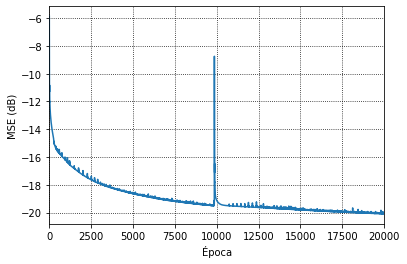

In [28]:
# Plotting loss
plt.plot(10*np.log10(history.history['loss']))
plt.xlim(0, 20000)
plt.grid(color='black', linestyle='dotted')
plt.ylabel('MSE (dB)')
plt.xlabel('Época')
plt.savefig('saved/residual_mse/error.eps', format='eps')
plt.show()

In [29]:
# Restoration of image from testing dataset
test_prediction = (1+model.predict(blurred_test))/2
test_prediction_tf = tf.convert_to_tensor(test_prediction, np.float64)

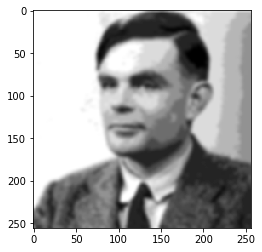

In [30]:
# Degraded image
plt.imshow(blurred_test[0, :, :, 0], cmap = 'gray')

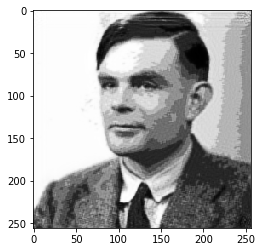

In [31]:
# Restored image
plt.imshow(test_prediction[0, :, :, 0], cmap = 'gray')
Image.fromarray((255*test_prediction[0, :, :, 0]).astype(np.uint8), mode='L').save('saved/residual_mse/rest.eps')

In [32]:
# SSIM between original and degraded pictures
tf.image.ssim(original_test_tf, blurred_test_tf, max_val=1).numpy()

array([0.77463263, 0.77463263], dtype=float32)

In [33]:
# SSIM between original and restored pictures
tf.image.ssim(original_test_tf, test_prediction_tf, max_val=1).numpy()

array([0.8865642, 0.8865642], dtype=float32)

In [34]:
# Saving model
model.save('saved/residual_mse/model.h5')